Train a GPR model with "RDkit featurization" and check performance by r2_score, MSE, MAE

In [ ]:
# Train a GPR model with RDkit featurization
import deepchem as dc
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
#load the dataset (polymer smiles and their energy of atomization)

print("loading the data...")
loader = dc.data.CSVLoader(["Eat"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors())
Data = loader.create_dataset('../csv_files/Polymers_Eat.csv')

loading the data...


In [3]:
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0.0)

#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["Ei"])

In [26]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Dataset)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [33]:
#preprocess the data
scaler = preprocessing.StandardScaler().fit(train_dataset.X)
X_scaled = scaler.transform(train_dataset.X)
train_dataset = dc.data.DiskDataset.from_numpy(X=X_scaled, y=train_dataset.y, w=train_dataset.w, ids=train_dataset.ids, tasks = ["Ei"])

#preprocess the data
scaler = preprocessing.StandardScaler().fit(test_dataset.X)
X_scaled = scaler.transform(test_dataset.X)
test_dataset = dc.data.DiskDataset.from_numpy(X=X_scaled, y=test_dataset.y, w=test_dataset.w, ids=test_dataset.ids, tasks = ["Ei"])

In [34]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct

kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


model is fitted


In [35]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.9999999999999998}
Test set score: {'pearson_r2_score': 0.9665766272895199}


In [36]:
#calculate MSE score
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_squared_error': 3.7035227655182236e-17}
Test set score: {'mean_squared_error': 0.006695786525248594}


In [37]:
#convert tekst to string, so it can be depicted in matplotlib
number=list(test_score.values())[0]
text = "r2= "+ str(round(number,3))

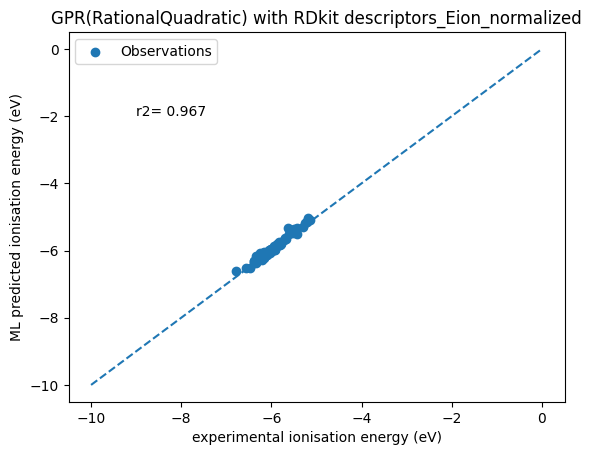

In [38]:
#plot the data
import matplotlib.pyplot as plt

x=[-10,0]
y=[-10,0]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental ionisation energy (eV)")
plt.ylabel("ML predicted ionisation energy (eV)")
plt.title("GPR(RationalQuadratic) with RDkit descriptors_Eion_normalized")
plt.text(-9,-2,text)
plt.show()
